# Gate Leakage using multiple QDAC-IIs

In [1]:
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
from qcodes_contrib_drivers.drivers.QDevil import QDAC2
from qcodes_contrib_drivers.drivers.QDevil import QDAC2_Array
qdac1_addr = '192.168.8.17'
qdac1 = QDAC2.QDac2('QDAC_1', visalib='@py', address=f'TCPIP::{qdac1_addr}::5025::SOCKET')
qdac2_addr = '192.168.8.19'
qdac2 = QDAC2.QDac2('QDAC_2', visalib='@py', address=f'TCPIP::{qdac2_addr}::5025::SOCKET')

Connected to: QDevil QDAC-II (serial:3, firmware:11-1.14) in 0.21s
Connected to: QDevil QDAC-II (serial:2, firmware:11-1.14) in 0.25s


In [2]:
# Connect the two QDAC-IIs together as described in section 5.5 of the manual
qdacs = QDAC2_Array.QDac2_Array(qdac1, [qdac2])
controller, listener, *_ = qdacs.names
print(f'Controller: {controller}')
print(f'Listener: {listener}')

Controller: QDAC_1
Listener: QDAC_2


In [7]:
# For testing, connect resistors: 
# - Controller: 33M between ch 3 & 4, and 5G over ch 1 
# - Listener: 47M over ch 1 and 5M6 over ch 3
contacts = {controller: {'G1': 1, 'G2': 2, 'G3': 3, 'G4': 4},
            listener: {'G5': 1, 'O6': 3}}
arrangement = qdacs.arrange(contacts)
arrangement.set_virtual_voltages({
    'G1': 0.01, 'G2': 0.015, 'G3': 0.013, 'G4': 0.021, 'G5': 0.005, 'O6': 0.011})
sleep(3)

In [8]:
# Measure leakage by raising the voltage by 3 mV on each channel in turn. 
modulation_mV=3
powerline_cycles=2
leakage_matrix_Ohm = arrangement.leakage(
    modulation_V=modulation_mV/1000, nplc=powerline_cycles)

In [9]:
leakage_megaohm = leakage_matrix_Ohm / 1e6

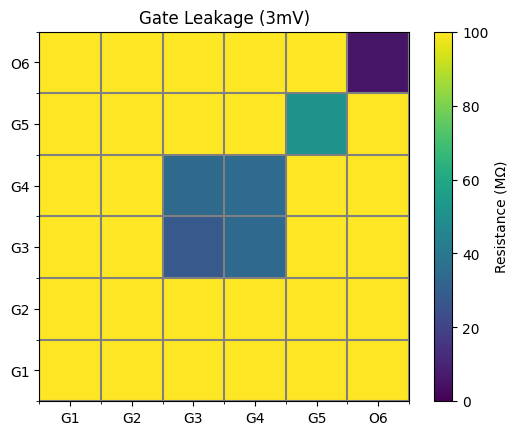

In [10]:
# Show the leakage matrix but cap it off at 100 MΩ
fig, ax = plt.subplots()
plt.title(f'Gate Leakage ({modulation_mV}mV)')
img = ax.imshow(leakage_megaohm, interpolation='none', vmin=0, vmax=100)
ticks = np.arange(len(arrangement.contact_names))
minorticks = np.arange(-0.5, len(ticks), 1)
ax.set_xticks(ticks, labels=arrangement.contact_names)
ax.set_yticks(ticks, labels=arrangement.contact_names)
ax.set_xticks(minorticks, minor=True)
ax.set_yticks(minorticks, minor=True)
ax.grid(which='minor', color='grey', linewidth=1.5)
plt.gca().invert_yaxis()
colorbar = fig.colorbar(img)
colorbar.set_label('Resistance (MΩ)')